<a href="https://www.kaggle.com/code/nikhil1e9/goodreads-books-analysis?scriptVersionId=174761850" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from collections import defaultdict

%matplotlib inline
sns.set(style="darkgrid", palette="Set2")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load data

In [2]:
# Function to load the data
def load_data(path):
    df = pd.read_csv(path)
    df = df.iloc[:, 1:]
    return df

filepath = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filepath.append(os.path.join(dirname, filename))
        
books_df = load_data(filepath[0])
genres_df = load_data(filepath[1])
desc_df = load_data(filepath[2])

In [3]:
books_df.sample(5)

,Title,Author,Score,Ratings,Published
2129,Do You Remember?,Freida McFadden,4.14,23766,2022
2778,Open Throat,Henry Hoke,4.10,1704,2023
1161,1964: Eyes of the Storm,Paul McCartney,4.53,199,2023
2218,Radical: Taking Back Your Faith from the Ameri...,David Platt,4.18,61484,2010
1990,Primer 1,Jennifer Muro,4.02,5260,2020


In [4]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4621 entries, 0 to 4620
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Title      4621 non-null   object 
 1   Author     4621 non-null   object 
 2   Score      4621 non-null   float64
 3   Ratings    4621 non-null   int64  
 4   Published  4621 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 180.6+ KB


In [5]:
books_df.isnull().sum()

Title        0
Author       0
Score        0
Ratings      0
Published    0
dtype: int64

No null values found

In [6]:
books_df.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
Score,4621.000000,4.096048,0.308495,2.430000,3.910000,4.120000,4.300000,5.000000
Ratings,4621.000000,135836.193681,433372.008815,1.000000,1225.000000,9670.000000,75203.000000,9444576.000000
Published,4621.000000,2000.326769,155.057223,-700.000000,2015.000000,2021.000000,2023.000000,2023.000000


# Data Cleaning

Some book titles contain the series names to which they belong. Let's separate them out and create a new feature with the series names.

In [7]:
books_df['Series'] = books_df['Title'].apply(lambda x: x.split('(')[1][:-3].strip().split(',')[0] if len(x.split('('))>1 else "Unknown")
books_df['Title'] = books_df['Title'].apply(lambda x: x.split('(')[0])
books_df[books_df['Series'] != "Unknown"].sample(5)

,Title,Author,Score,Ratings,Published,Series
2291,A Study in Scarlet,Arthur Conan Doyle,4.14,421446,1887,Sherlock Holmes
684,薬屋のひとりごと 5 [Kusuriya no Hitorigoto 5],Nekokurage,4.37,2401,2019,The Apothecary Diaries [Nekokurage]
554,The Tourist Attraction,Sarah Morgenthaler,3.53,31041,2020,Moose Springs
1936,Is Everyone Hanging Out Without Me?,Mindy Kaling,3.86,484165,2011,And Other Concer
99,Magic Bites,Ilona Andrews,4.06,121844,2007,Kate Daniels


In [8]:
series_unknown = books_df[books_df['Series'] != "Unknown"].shape[0]
print("Books for which series is not known:", series_unknown)

Books for which series is not known: 1303


# EDA

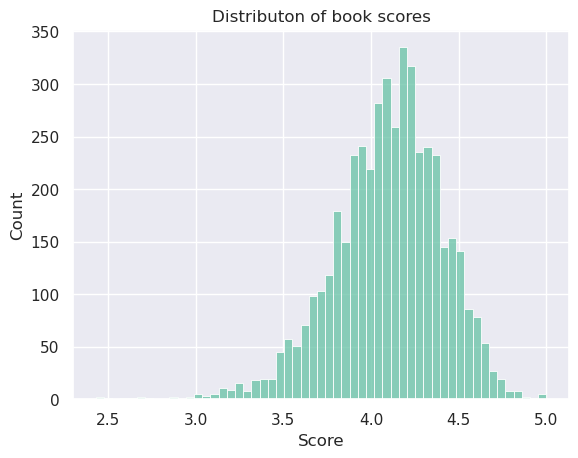

In [9]:
sns.histplot(data=books_df, x='Score')
plt.title("Distributon of book scores")
plt.show()

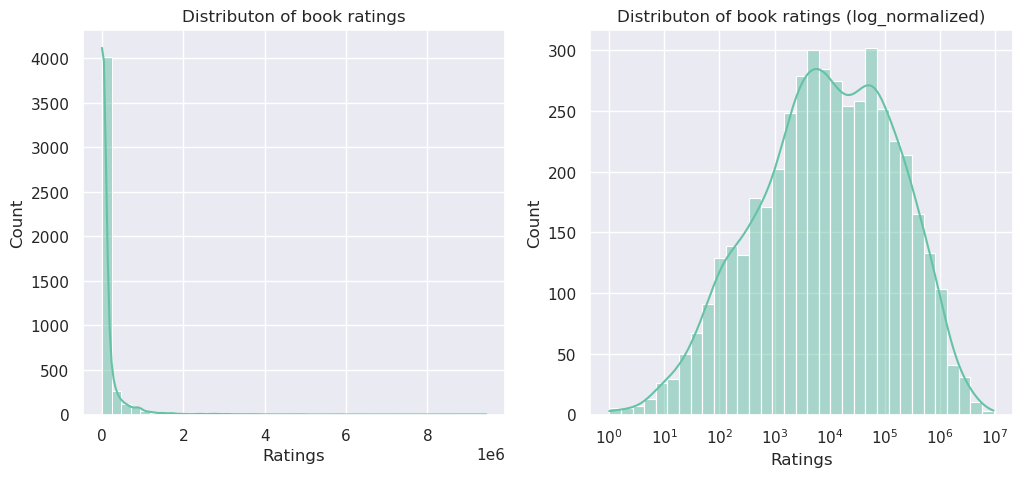

In [10]:
fig, axes = plt.subplots(1,2,figsize=(12,5))

sns.histplot(data=books_df, x='Ratings', bins=40, kde=True, ax=axes[0])
axes[0].set_title("Distributon of book ratings")

sns.histplot(data=books_df, x='Ratings', log_scale=True, kde=True, ax=axes[1])
axes[1].set_title("Distributon of book ratings (log_normalized)")

plt.show()

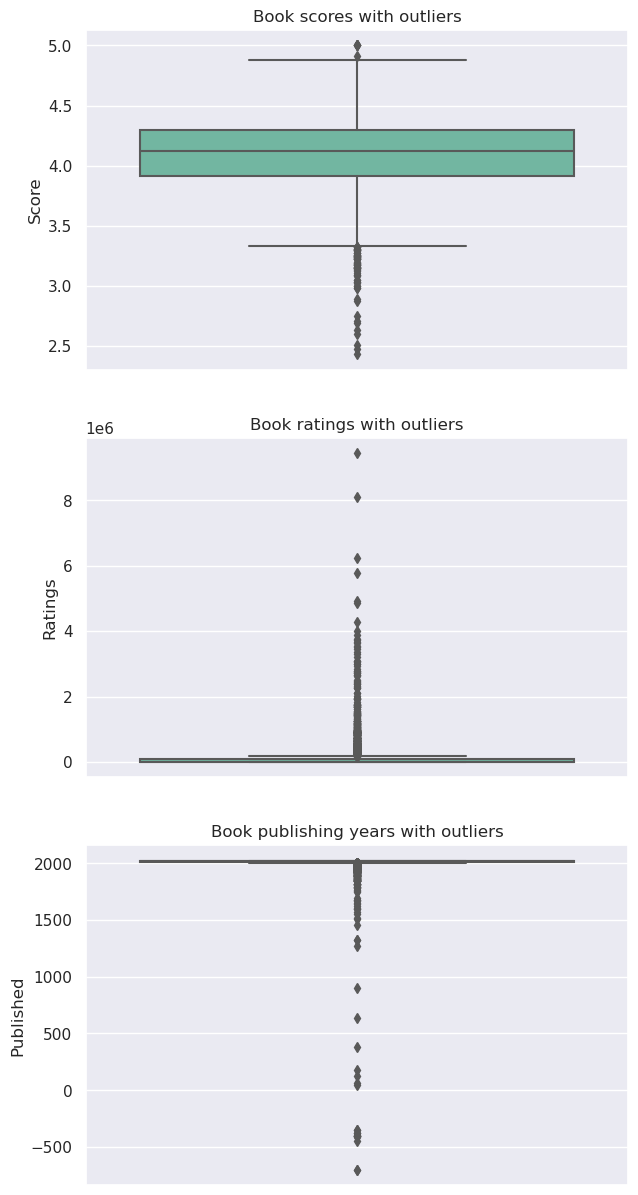

In [11]:
fig, axes = plt.subplots(3,1,figsize=(7,15))

sns.boxplot(data=books_df, y='Score', ax=axes[0])
axes[0].set_title("Book scores with outliers")

sns.boxplot(data=books_df, y='Ratings', ax=axes[1])
axes[1].set_title("Book ratings with outliers")

sns.boxplot(data=books_df, y='Published', ax=axes[2])
axes[2].set_title("Book publishing years with outliers")

plt.show()

The Publishing year column and the Ratings column doesn't have a typical shape for the boxplot due to a large number of outliers. Most of the Book Ratings are near to zero as these contain ratings for trending and newer books that have been recently released. This trend is evident due to the distribution of the Published column which contain books ranging from year -700 i.e. *Before Common Era* (BCE) all the way to the latest year.

In [12]:
books_df['Published'].value_counts()[:10]

2023    1490
2022     583
2021     401
2020     331
2019     286
2018     226
2016      54
2014      53
2015      50
2006      49
Name: Published, dtype: int64

The data has more books from the recent years compared to the past years. I will be treating the books published in or after 2020 (the new decade) to be the new ones and before 2020 to be the old ones.

In [13]:
new_books = books_df[books_df['Published'] >= 2020]
old_books = books_df[books_df.Published.isin(new_books.Published) == False]

print(f"{len(new_books)} books are published in 2020 and beyond")
print(f"{len(old_books)} books are published before 2020")

2805 books are published in 2020 and beyond
1816 books are published before 2020


# Answering interesting questions

### Q. Which are the top 10 most popular books?

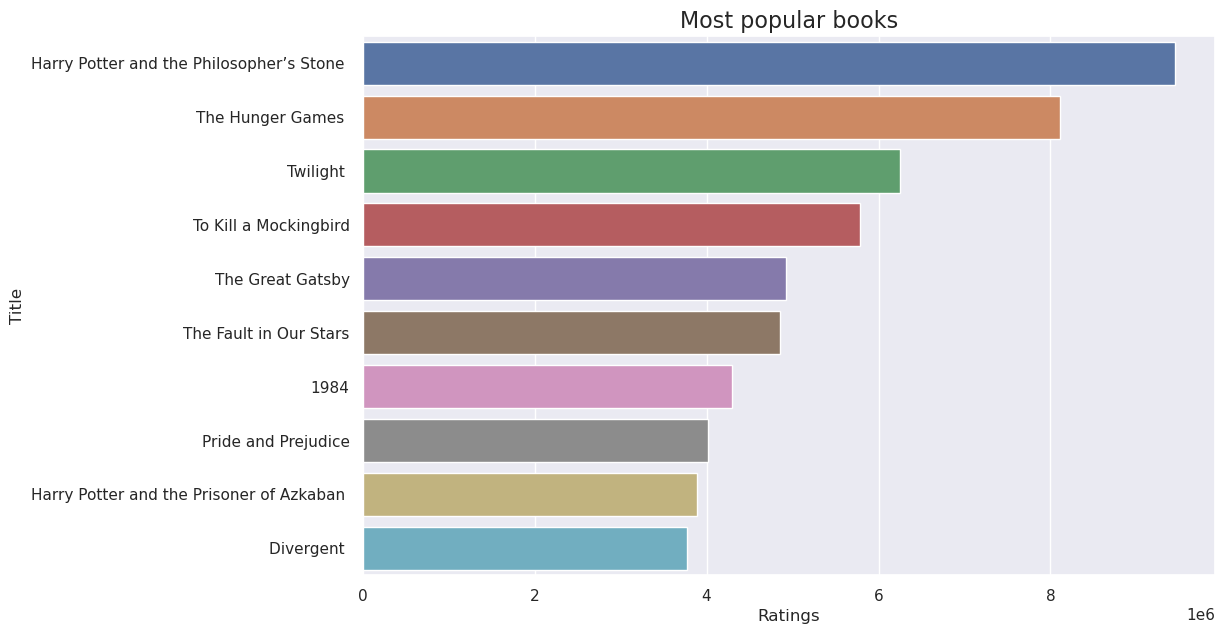

In [14]:
plt.figure(figsize=(11,7))
popular_df = books_df.sort_values('Ratings', ascending=False)[:10]
sns.barplot(data=popular_df, x='Ratings', y='Title', palette='deep')
plt.title("Most popular books", fontsize=16)
plt.show()

Harry Potter, Hunger Games and Twilight are the most popular ones

### Q. Who are the most popular authors?

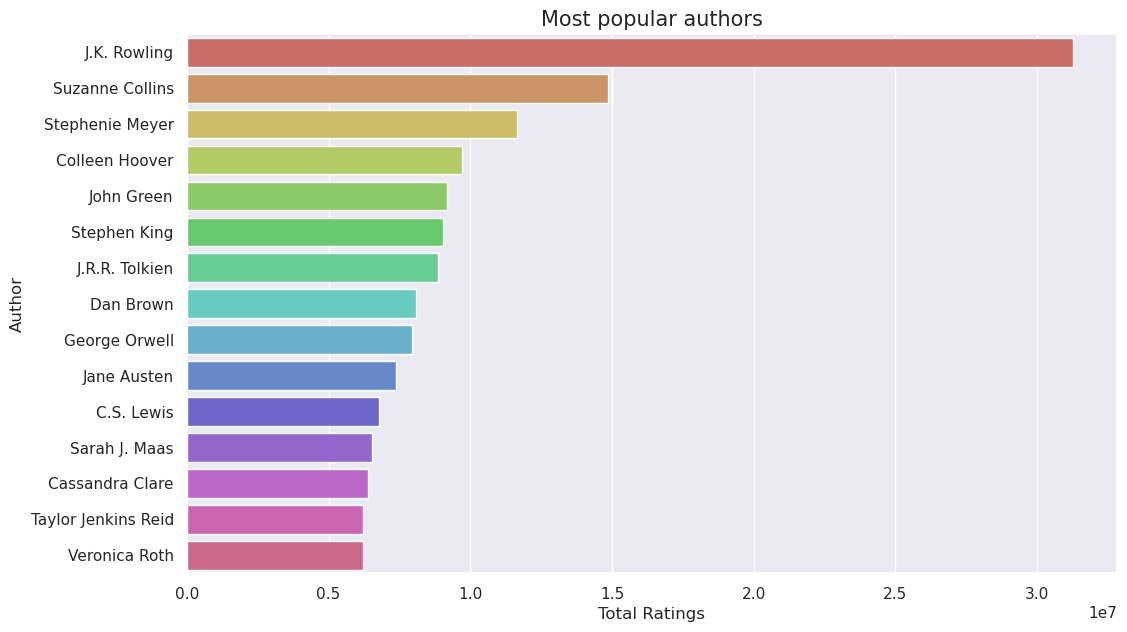

In [15]:
plt.figure(figsize=(12,7))
author_df = books_df.groupby('Author')['Ratings'].sum().sort_values(ascending=False)[:15].reset_index()
sns.barplot(data=author_df, x='Ratings', y='Author', palette='hls')
plt.xlabel("Total Ratings")
plt.title("Most popular authors", fontsize=15)
plt.show()

**J.K. Rowling** is the most popular author leading others by a large margin. **Suzanne Collins** and **Stephanie Meyer** follow with 2nd and 3rd place respectively.

### Q. What are the top 10 most popular book series?

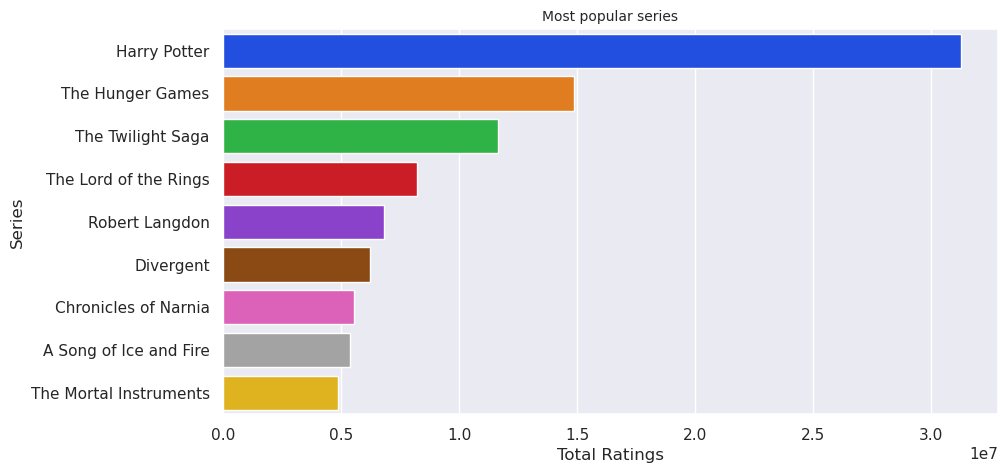

In [16]:
plt.figure(figsize=(10,5))
series_df = books_df.groupby('Series')['Ratings'].sum().sort_values(ascending=False)[1:10].reset_index()
sns.barplot(data=series_df, x='Ratings', y='Series', palette='bright')
plt.xlabel("Total Ratings")
plt.title("Most popular series", fontsize=10)
plt.show()

As usual the most popular book series are **Harry Potter, Hunger Games, Twilight Saga, and Lord of the Rings.**

### Q. Which authors have written the most books from our dataset?

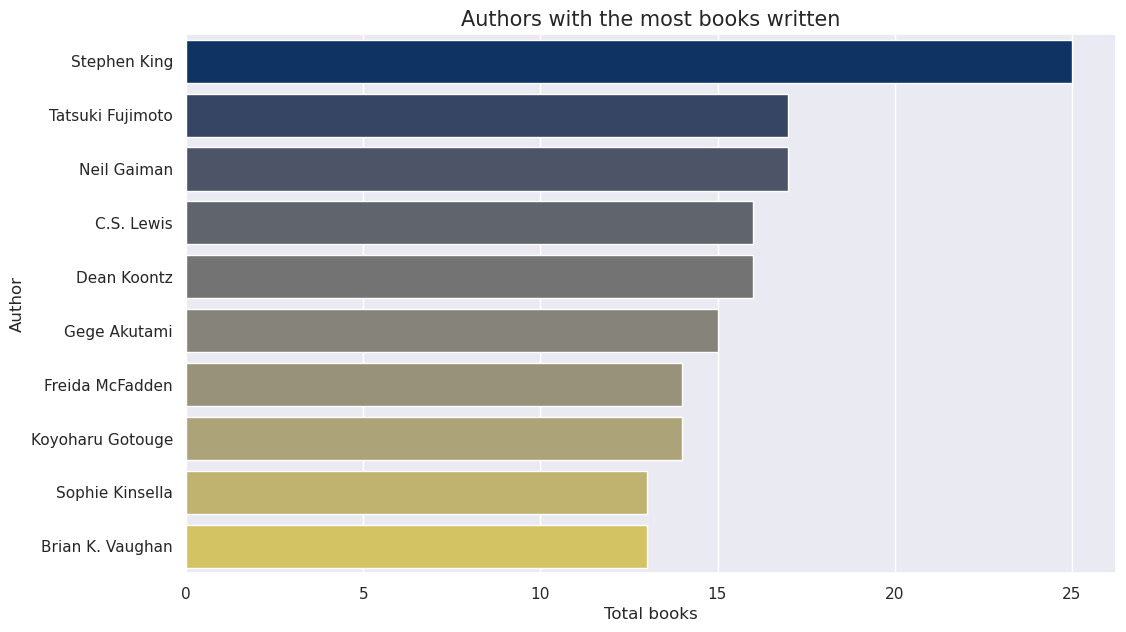

In [17]:
plt.figure(figsize=(12,7))
most_books = books_df.groupby('Author')['Title'].count().sort_values(ascending=False)[:10].reset_index()
sns.barplot(data=most_books, x='Title', y='Author', palette='cividis')
plt.xlabel("Total books")
plt.title("Authors with the most books written", fontsize=15)
plt.show()

**Stephen King** has the most books(25) written among all authors. Horror Stuff!!😱

### Q. Which are the best books according to the readers?

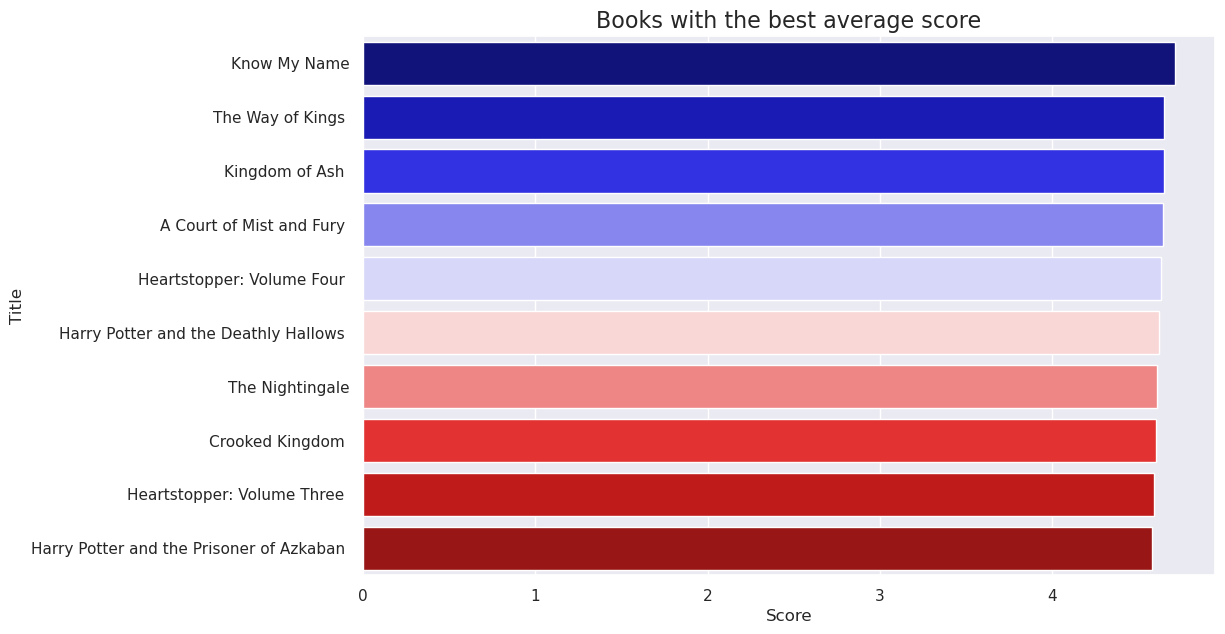

In [18]:
# Considering books with a score of 4.5 and above and ratings greater than 100,000
plt.figure(figsize=(11,7))
best_df = books_df[books_df.Ratings > 100_000].sort_values('Score', ascending=False)[:10]
sns.barplot(data=best_df, x='Score', y='Title', palette='seismic')
plt.title("Books with the best average score", fontsize=16)
plt.show()

## Genre Analysis

In [19]:
genres_df.sample(5)

,Title,Genre
879,I Contain Multitudes: The Microbes Within Us a...,Science
3838,Bellegarde,"Contemporary,Historical Fiction,Young Adult"
880,Israel: A Simple Guide to the Most Misundersto...,Religion
2928,"Hey, Kiddo: How I Lost My Mother, Found My Fat...",Art
3399,A Taste for Poison: Eleven Deadly Molecules an...,Science


Some books have multiple genres. Let's analyze how many different type of genres we have.

In [20]:
genres_unique = set()
for genre_comb in genres_df.Genre.unique():
    all_genres = genre_comb.split(',')
    for genre in all_genres:
        genres_unique.add(genre)

print(genres_unique)
print(f"\nThere are {len(genres_unique)} genres in total")

{'Contemporary', 'Humor', 'Science', 'Paranormal', 'Horror', 'Young Adult', 'Mystery', 'Biography', 'Self Help', 'Memoir', 'Art', 'Graphic Novels', 'Fantasy', 'Religion', 'Historical Fiction', 'Sports', 'Philosophy', 'Travel', 'Christian', 'Music', 'Fiction', 'Comics', 'Classics', 'Crime', 'Suspense', 'Science Fiction', 'Thriller', 'Psychology', 'Spirituality', 'Business', 'Cookbooks', 'Nonfiction', 'LGBT', 'History', 'Chick Lit', 'Childrens', 'Manga', 'Romance', 'Poetry'}

There are 39 genres in total


Now let's also checkout which genres are the most prevalent in our dataset.

In [21]:
# most frequently occuring genres
genre_freq = defaultdict(int)
for genre_comb in genres_df.Genre.unique():
    all_genres = genre_comb.split(',')
    for genre in all_genres:
        genre_freq[genre] += 1

print(sorted(genre_freq.items(), key=lambda x: x[1], reverse=True)[:5])

[('Fiction', 123), ('Mystery', 102), ('Contemporary', 101), ('Thriller', 99), ('Nonfiction', 92)]


**Fiction, Mystery**, and **Thriller** are the most frequently occuring genres among all.

## Book Description Analysis

# Recommendation System

This notebook is currently under progress. I am working on more fun stuff and will be coming out with a new version of the notebook in a couple days. Stay tuned until then. 

If you liked the notebook or found it helpful you can consider giving it an upvote👍. It would be much appreciated. For more interesting stuff you can check out my other notebooks and datasets. 